In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from os import path
import sys
sys.path.append(path.join(".."))

import saly
import saly.backend as S
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

EPOCHS = 25
SPECIES = 'Mouse'
DATA_PATH = '/home/mlongar/Data/SingleCellGeneExpression/'
DATASET_HRVATIN_PATH = DATA_PATH + 'hrvatin_2018.h5ad' 
DATASET_CHEN_PATH = DATA_PATH + 'chen_2017.h5ad'
DATASET_BIG_PATH = DATA_PATH + 'cao_2019.h5ad' #'10x_mouse_1.3mln.h5ad'
MARKER_PATH = DATA_PATH + 'panglao_gene_markers.tab.gz'

Using TensorFlow backend.


In [2]:
hrvatin_data = saly.load_h5ad(DATASET_HRVATIN_PATH)
print("HRVATIN DATA\n", hrvatin_data.shape)

HRVATIN DATA
 (48266, 25186)


In [3]:
chen_data = saly.load_h5ad(DATASET_CHEN_PATH)
print("CHEN DATA\n", chen_data.shape)

CHEN DATA
 (14437, 23284)


In [4]:
big_data = saly.load_h5ad(DATASET_BIG_PATH)
print("BIG DATA\n", big_data.shape)

BIG DATA
 (2058652, 26158)


In [5]:
chen_data = saly.drop_rows(chen_data, ['tanycyte', 'unknown', 'ependymal cell', 'epithelial cell'])

Dropped 4750 cell(s). New shape: (9687, 23284)


In [6]:
markers_db = saly.load_markers(MARKER_PATH, SPECIES)
markers = saly.get_mutual_markers([hrvatin_data, chen_data, big_data], markers_db)
print('Mutual markers:', len(markers))

Mutual markers: 6815


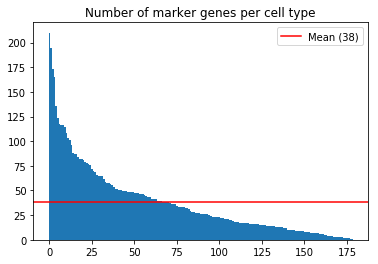

In [7]:
saly.plot_marker_genes(markers)

In [8]:
marker_aliases = {'Neuron' : 'Neurons',
                'Oligodendrocyte' : 'Oligodendrocytes',
                'Muscle cell' : 'Smooth muscle cells',
                'Endothelial cell' : 'Endothelial cells',
                'Astrocyte' : 'Astrocytes',
                'Macrophage' : 'Macrophages',
                'OPC' : 'Oligodendrocyte progenitor cells',
                'Pericyte' : 'Pericytes'}

saly.check_labels([hrvatin_data, chen_data], markers, marker_aliases)

In [9]:
hrvatin_data = saly.drop_unused_genes(hrvatin_data, markers)
chen_data = saly.drop_unused_genes(chen_data, markers)
big_data = saly.drop_unused_genes(big_data, markers)

saly.check_shape([hrvatin_data, chen_data, big_data])

Dropped 21450 gene(s). New shape: (48266, 3736)
Dropped 19548 gene(s). New shape: (9687, 3736)
Dropped 22422 gene(s). New shape: (2058652, 3736)


In [10]:
big_data = saly.mark_as_unlabelled(big_data.copy())

In [11]:
train_data, _, _ = saly.preprocess_data(big_data, splits=10,
                                       train=1, test=0, validation=0)

In [12]:
chen_data = S.normalize_data(chen_data.copy())
hrvatin_data = S.normalize_data(hrvatin_data.copy())

In [13]:
model, marker_model, encoder_model = saly.build_model(train_data, markers, supervised=False);

In [14]:
chen_cell_activations = marker_model.predict(chen_data.X)
saly.get_results(chen_data.obs['labels'], chen_cell_activations, markers, marker_aliases)

Correct predictions: 7305 out of 9687 (75.41%)
	Neuron: 99.7% (2308/2315) | Markers: 195
	Oligodendrocyte: 97.54% (3454/3541) | Markers: 82
	OPC: 0.0% (0/1792) | Markers: 26
	Astrocyte: 75.87% (871/1148) | Markers: 59
	Microglia: 74.45% (539/724) | Markers: 78
	Macrophage: 79.64% (133/167) | Markers: 116


In [15]:
hrvatin_cell_activations = marker_model.predict(hrvatin_data.X)
saly.get_results(hrvatin_data.obs['labels'], hrvatin_cell_activations, markers, marker_aliases)

Correct predictions: 43837 out of 48266 (90.82%)
	Neuron: 98.02% (14922/15223) | Markers: 195
	Oligodendrocyte: 93.51% (8070/8630) | Markers: 82
	Muscle cell: 0.0% (0/621) | Markers: 77
	Astrocyte: 93.54% (6584/7039) | Markers: 59
	Endothelial cell: 99.97% (3449/3450) | Markers: 173
	Macrophage: 98.32% (528/537) | Markers: 116
	Microglia: 97.92% (9947/10158) | Markers: 78
	OPC: 2.41% (44/1826) | Markers: 26
	Pericyte: 37.47% (293/782) | Markers: 62


In [16]:
history = saly.train_model(model, train_data, markers, marker_aliases,
                           EPOCHS, validation_data=chen_data, verbose=1)

Train on 2058652 samples, validate on 9687 samples
Epoch 1/25
2058652/2058652 [==============================] - 136s 66us/step - loss: 1809.8426 - cell_activations_loss: 0.0000e+00 - output_loss: 1.8098 - cell_activations_marker_prediction_metric: 0.0000e+00 - val_loss: 3696.5322 - val_cell_activations_loss: 0.0000e+00 - val_output_loss: 3.6965 - val_cell_activations_marker_prediction_metric: 0.6990
Epoch 2/25
2058652/2058652 [==============================] - 144s 70us/step - loss: 1754.7621 - cell_activations_loss: 0.0000e+00 - output_loss: 1.7548 - cell_activations_marker_prediction_metric: 0.0000e+00 - val_loss: 3596.7316 - val_cell_activations_loss: 0.0000e+00 - val_output_loss: 3.5967 - val_cell_activations_marker_prediction_metric: 0.6312
Epoch 3/25
2058652/2058652 [==============================] - 149s 72us/step - loss: 1742.5309 - cell_activations_loss: 0.0000e+00 - output_loss: 1.7425 - cell_activations_marker_prediction_metric: 4.8575e-07 - val_loss: 3565.0320 - val_cell_a

2058652/2058652 [==============================] - 146s 71us/step - loss: 1702.3999 - cell_activations_loss: 0.0000e+00 - output_loss: 1.7024 - cell_activations_marker_prediction_metric: 1.4573e-06 - val_loss: 3555.5603 - val_cell_activations_loss: 0.0000e+00 - val_output_loss: 3.5556 - val_cell_activations_marker_prediction_metric: 0.2704
Epoch 25/25
2058652/2058652 [==============================] - 150s 73us/step - loss: 1702.0492 - cell_activations_loss: 0.0000e+00 - output_loss: 1.7020 - cell_activations_marker_prediction_metric: 2.4288e-06 - val_loss: 3552.8332 - val_cell_activations_loss: 0.0000e+00 - val_output_loss: 3.5528 - val_cell_activations_marker_prediction_metric: 0.2247


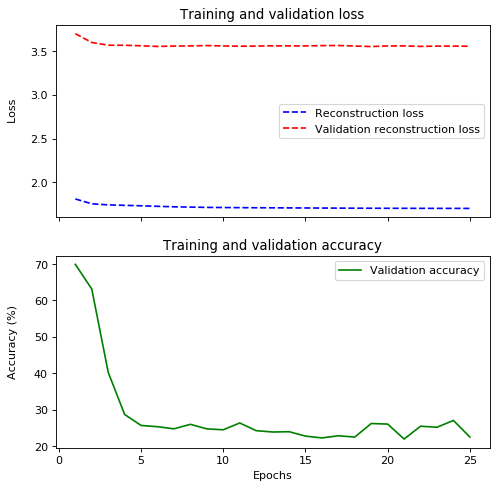

In [17]:
saly.plot_model_history(history, supervised=False, labelled_training=False)

In [18]:
chen_cell_activations = marker_model.predict(chen_data.X)
saly.get_results(chen_data.obs['labels'], chen_cell_activations, markers, marker_aliases)

Correct predictions: 2177 out of 9687 (22.47%)
	Neuron: 87.17% (2018/2315) | Markers: 195
	Oligodendrocyte: 0.0% (0/3541) | Markers: 82
	OPC: 0.0% (0/1792) | Markers: 26
	Astrocyte: 0.0% (0/1148) | Markers: 59
	Microglia: 16.3% (118/724) | Markers: 78
	Macrophage: 24.55% (41/167) | Markers: 116


In [19]:
hrvatin_cell_activations = marker_model.predict(hrvatin_data.X)
saly.get_results(hrvatin_data.obs['labels'], hrvatin_cell_activations, markers, marker_aliases)

Correct predictions: 18353 out of 48266 (38.02%)
	Neuron: 96.24% (14650/15223) | Markers: 195
	Oligodendrocyte: 0.09% (8/8630) | Markers: 82
	Muscle cell: 0.0% (0/621) | Markers: 77
	Astrocyte: 0.09% (6/7039) | Markers: 59
	Endothelial cell: 77.39% (2670/3450) | Markers: 173
	Macrophage: 46.55% (250/537) | Markers: 116
	Microglia: 7.57% (769/10158) | Markers: 78
	OPC: 0.0% (0/1826) | Markers: 26
	Pericyte: 0.0% (0/782) | Markers: 62
